torch.Size([793, 6, 200])
(6, 200)


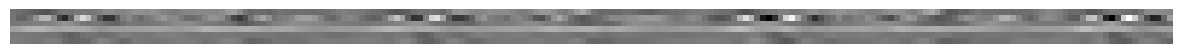

In [ ]:
import numpy as np
import matplotlib.pyplot as plts
import torch

# Path to your file
file_path = 'data/200/X_test_all.pt'

# Load the file
X = torch.tensor(torch.load(file_path), dtype=torch.float32).permute(0, 3, 1, 2).squeeze()
print(X.shape)

# Extract a sample
sample = X[9:10]

# Convert the sample to numpy array and remove the singleton dimension
sample_np = sample.squeeze().numpy()
print(sample_np.shape)

def show_img(img):
    plt.figure(figsize=(15, 6))  # Adjusted size for better visibility
    plt.imshow(img, cmap='gray')  # Using 'gray' colormap for clarity if image is single channel
    plt.axis('off')  # Optionally hide axes
    plt.show()

# Show the image
show_img(sample_np)


## Attention Map for Reconstruction Objective

Change the model loading code accordingly.

In [6]:
from leo_model_mae import MaskedAutoencoderViT
import timm

## TODO: Load model
checkpoint_name = 'leo_mae_p20_aug_checkpoint-200.pth'
model = MaskedAutoencoderViT(ts_len=200,patch_size=20,bert_pos_embed=False)
checkpoint = torch.load('../persistent-data/leo/output_dir/'+checkpoint_name,map_location='cpu')

#checkpoint = torch.load('output_dir/ch_ind_normalize_checkpoint-9999.pth',map_location='cpu')
checkpoint_model = checkpoint['model']
    
msg = model.load_state_dict(checkpoint_model, strict=False)


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

MASK_RATIO = 0
DEVICE = 'cuda'

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        #print('input shape:',x.shape)
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        #attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward



In [8]:
#x = X.to(DEVICE)
model = model.to(DEVICE)
print(model.blocks[-1].attn)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

#y = model(x,mask_ratio=MASK_RATIO)
#attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()


#print(attn_map.shape)

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)


## Individual Sample Demo

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def show_attention_map(attn_map):
    # Ensure the attention map is a numpy array
    attn_map = attn_map.numpy() if isinstance(attn_map, torch.Tensor) else attn_map
    
    num_variates = attn_map.shape[0]
    num_patches = int(10*(1-MASK_RATIO))+1 # Assuming 10 patches + 1 for variate

    # Define labels for x and y axes
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z","Acc_X","Acc_Y", "Acc_Z"]
    x_labels = [f'{variate_labels[i]}_cls' if j == 0 else f'{variate_labels[i]}_{j}' for i in range(num_variates) for j in range(num_patches)]
    y_labels = x_labels

    plt.figure(figsize=(10, 10))  # Adjust size as needed
    plt.imshow(attn_map, cmap='Blues', interpolation='nearest')
    plt.colorbar()  # Add a color bar to show the scale
    plt.title(checkpoint_name + ' Attention Map')

    # Set x and y axis labels
    plt.xticks(ticks=np.arange(num_patches*num_variates), labels=x_labels, rotation=90, fontsize=8)
    plt.yticks(ticks=np.arange(num_patches*num_variates), labels=y_labels, fontsize=8)
    
    # Optionally hide the axes if needed
    plt.axis('on')  # Change to 'off' if you prefer to hide the axes
    
    plt.show()
    
def show_reduced_attention_map(attn_map):
    num_variates = attn_map.shape[0]
    num_patches_per_variate = int(10*(1-MASK_RATIO))+1

    # Initialize an empty tensor to store the reduced attention map
    reduced_attn_map = torch.zeros(num_variates, num_variates)

    # Compute the mean for each variate
    for i in range(num_variates):
        for j in range(num_variates):
            start_i = i * num_patches_per_variate
            end_i = start_i + num_patches_per_variate
            start_j = j * num_patches_per_variate
            end_j = start_j + num_patches_per_variate

            # Take the mean of the corresponding patches
            reduced_attn_map[i, j] = attn_map[start_i:end_i, start_j:end_j].mean()

    #variate_labels = [f'Var{i}' for i in range(num_variates)]
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z","Acc_X","Acc_Y", "Acc_Z"]

    plt.figure(figsize=(8, 8))  # Adjust size as needed
    im = plt.imshow(reduced_attn_map, cmap='Blues', interpolation='nearest')
    plt.colorbar()  # Add a color bar to show the scale
    plt.title( checkpoint_name+ ' Reduced Attention Map')
    
    # Set x and y axis labels
    plt.xticks(ticks=np.arange(num_variates), labels=variate_labels, rotation=90, fontsize=10)
    plt.yticks(ticks=np.arange(num_variates), labels=variate_labels, fontsize=10)
    
    # Add gridlines for better visualization
    #plt.grid(visible=True, which='both', axis='both', linestyle='--', color='gray', alpha=1)
    
    # Highlight major ticks
    plt.tick_params(axis='x', which='major', length=10, width=1)
    plt.tick_params(axis='y', which='major', length=10, width=1)

    plt.show()



In [ ]:
MASK_RATIO = 0.0
model = model.to('cpu')
y = model(sample,MASK_RATIO)
sample_attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
show_attention_map(sample_attn_map.cpu())
#MASK_RATIO = 0.0

In [ ]:
show_reduced_attention_map(sample_attn_map.cpu())

## Globoal pooling attention map (Last Layer)

In [12]:
from util.datasets import UCIHAR

dataset_train = UCIHAR(data_path='data/200', is_test=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

In [18]:
from tqdm import tqdm

model = model.to(DEVICE)

attn_map_list = []
for x,_ in tqdm(data_loader_train):
    x = x.to(DEVICE)
    y = model(x,mask_ratio=MASK_RATIO)
    
    attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach() # average all heads
    attn_map_list.append(attn_map)

    

  0%|          | 0/116 [00:00<?, ?it/s]

100%|██████████| 116/116 [00:03<00:00, 36.36it/s]


In [19]:
attn_map_all_batch = torch.cat(attn_map_list, dim=0)
print(attn_map_all_batch.shape)

torch.Size([1847, 66, 66])


torch.Size([66, 66])


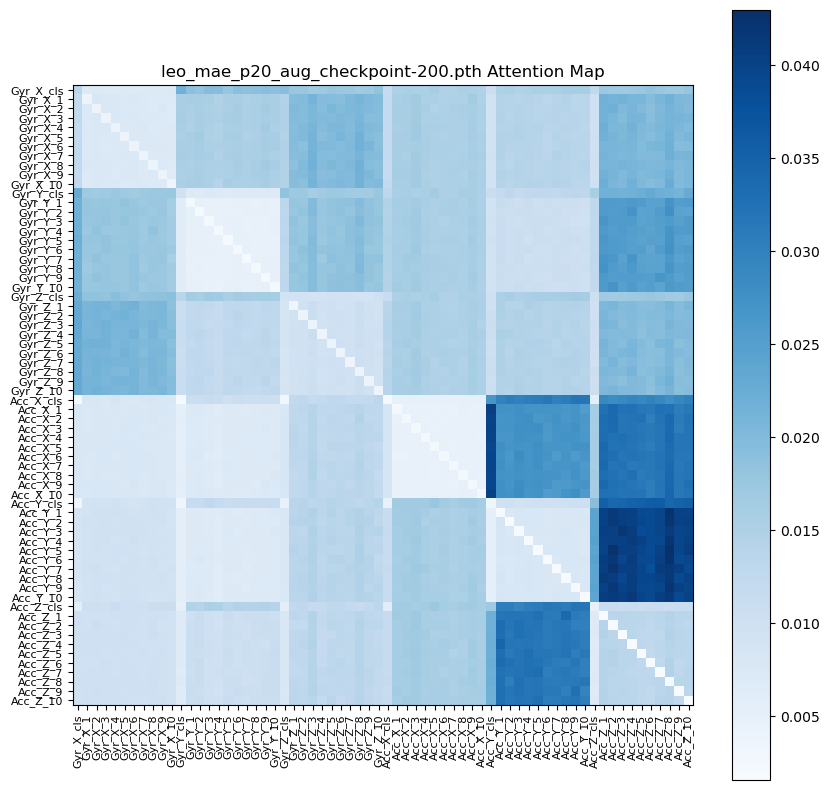

In [20]:
attn_map = attn_map_all_batch.mean(dim=0)
print(attn_map.shape)
show_attention_map(attn_map.cpu())

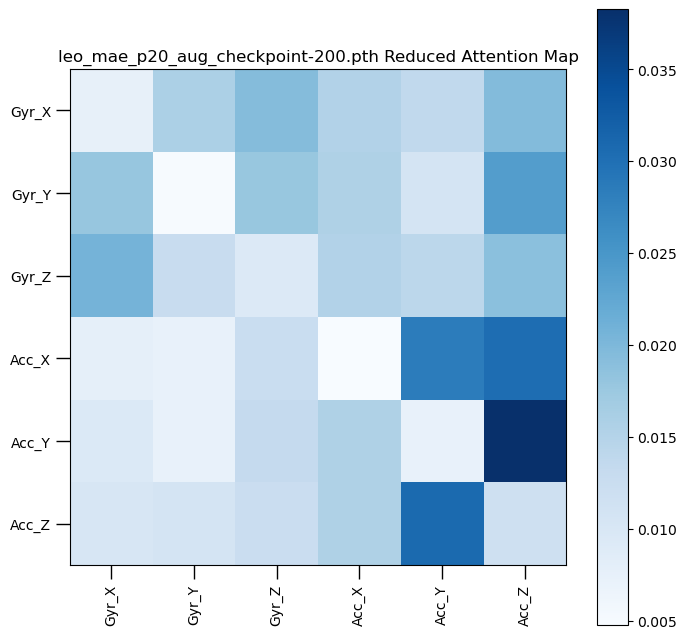

In [21]:
show_reduced_attention_map(attn_map.cpu())

### Conclusion: During reconstruction Gyr less important

## Finetune Attention Matrix

In [6]:
from leo_model_mae import MaskedAutoencoderViT
import timm
import torch
from main_linprobe import LinearProb

backbone = MaskedAutoencoderViT(ts_len=200,patch_size=20,bert_pos_embed=False)
model = LinearProb(backbone,num_classes=7)
checkpoint = torch.load('../persistent-data/leo/output_dir/downstream/leo_mae_mixup_p20_finetune_checkpoint-499.pth',map_location='cpu')

checkpoint_model = checkpoint['model']
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)




_IncompatibleKeys(missing_keys=['backbone.decoder_blocks.0.norm1.weight', 'backbone.decoder_blocks.0.norm1.bias', 'backbone.decoder_blocks.0.attn.qkv.weight', 'backbone.decoder_blocks.0.attn.qkv.bias', 'backbone.decoder_blocks.0.attn.proj.weight', 'backbone.decoder_blocks.0.attn.proj.bias', 'backbone.decoder_blocks.0.norm2.weight', 'backbone.decoder_blocks.0.norm2.bias', 'backbone.decoder_blocks.0.mlp.fc1.weight', 'backbone.decoder_blocks.0.mlp.fc1.bias', 'backbone.decoder_blocks.0.mlp.fc2.weight', 'backbone.decoder_blocks.0.mlp.fc2.bias', 'backbone.decoder_blocks.1.norm1.weight', 'backbone.decoder_blocks.1.norm1.bias', 'backbone.decoder_blocks.1.attn.qkv.weight', 'backbone.decoder_blocks.1.attn.qkv.bias', 'backbone.decoder_blocks.1.attn.proj.weight', 'backbone.decoder_blocks.1.attn.proj.bias', 'backbone.decoder_blocks.1.norm2.weight', 'backbone.decoder_blocks.1.norm2.bias', 'backbone.decoder_blocks.1.mlp.fc1.weight', 'backbone.decoder_blocks.1.mlp.fc1.bias', 'backbone.decoder_blocks.1

In [ ]:
print(model)

In [ ]:
model = model.to(DEVICE)
print(model.backbone.blocks[-1].attn)
model.backbone.blocks[-1].attn.forward = my_forward_wrapper(model.backbone.blocks[-1].attn)

## Global View

In [ ]:
downstream_attn_map_list = []
downstream_cls_attn_map_list = []
for x,_ in tqdm(data_loader_train):
    x = x.to(DEVICE)
    bs,nvar,ts_len = x.shape
    y = model(x,mask_ratio=0)
    attn_map = model.backbone.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach() # average all heads
    
    # to get CLS Token
    # Extract attention to each CLS token
    num_patches = int(10*(1-MASK_RATIO))+1
    cls_token_indices = [i * num_patches for i in range(nvar)]  # Adjust indices based on your setup
    cls_token_attn_map = attn_map[:, cls_token_indices, :]  # Select attention maps for all CLS tokens

    downstream_attn_map_list.append(attn_map)
    downstream_cls_attn_map_list.append(cls_token_attn_map)

downstream_attn_map_list= torch.cat(attn_map_list, dim=0)

downstream_cls_attn_map_list= torch.cat(downstream_cls_attn_map_list, dim=0)
downstream_cls_attn_map_list = downstream_cls_attn_map_list.mean(dim=0)
print(downstream_cls_attn_map_list.shape)

downstream_attn_map = downstream_attn_map_list.mean(dim=0)
print(downstream_attn_map.shape)
show_attention_map(downstream_attn_map.cpu())

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cls(attn_map, checkpoint_name, variate_labels):
    """
    Plots the attention map for CLS tokens attending to different patches.
    
    Parameters:
    - attn_map: Tensor containing the attention map (shape: 6x66)
    - checkpoint_name: Name of the checkpoint to use in the plot title
    - variate_labels: List of labels for the variates (e.g., ['Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Acc_X', 'Acc_Y', 'Acc_Z'])
    """
    num_variates = len(variate_labels)
    num_patches = attn_map.size(1) // num_variates  # Determine the number of patches per variate

    # Generate patch_labels and cls_labels based on the given variate_labels
    patch_labels = [f'{variate_labels[i]}_{j}' for i in range(num_variates) for j in range(1, num_patches)]
    cls_labels = [f'{variate_labels[i]}_cls' for i in range(num_variates)]

    # Increase the figure size to prevent label squeezing
    plt.figure(figsize=(14, 8))  # Adjust the size as needed

    # Plot the attention map
    plt.imshow(attn_map.cpu(), cmap='Blues', interpolation='nearest')
    plt.colorbar()  # Add a color bar to show the scale
    plt.title(checkpoint_name + ' Reduced Attention Map', fontsize=16)

    # Set x and y axis labels
    plt.xticks(ticks=np.arange(num_variates * (num_patches - 1)), labels=patch_labels, rotation=90, fontsize=12)  # x-axis for patches
    plt.yticks(ticks=np.arange(num_variates), labels=cls_labels, fontsize=12)  # y-axis for CLS tokens

    plt.xlabel('Patches', fontsize=14)
    plt.ylabel('CLS Tokens', fontsize=14)

    # Adjust the layout to fit the labels
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# plot_cls(downstream_cls_attn_map_list, "Checkpoint_01", ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"])


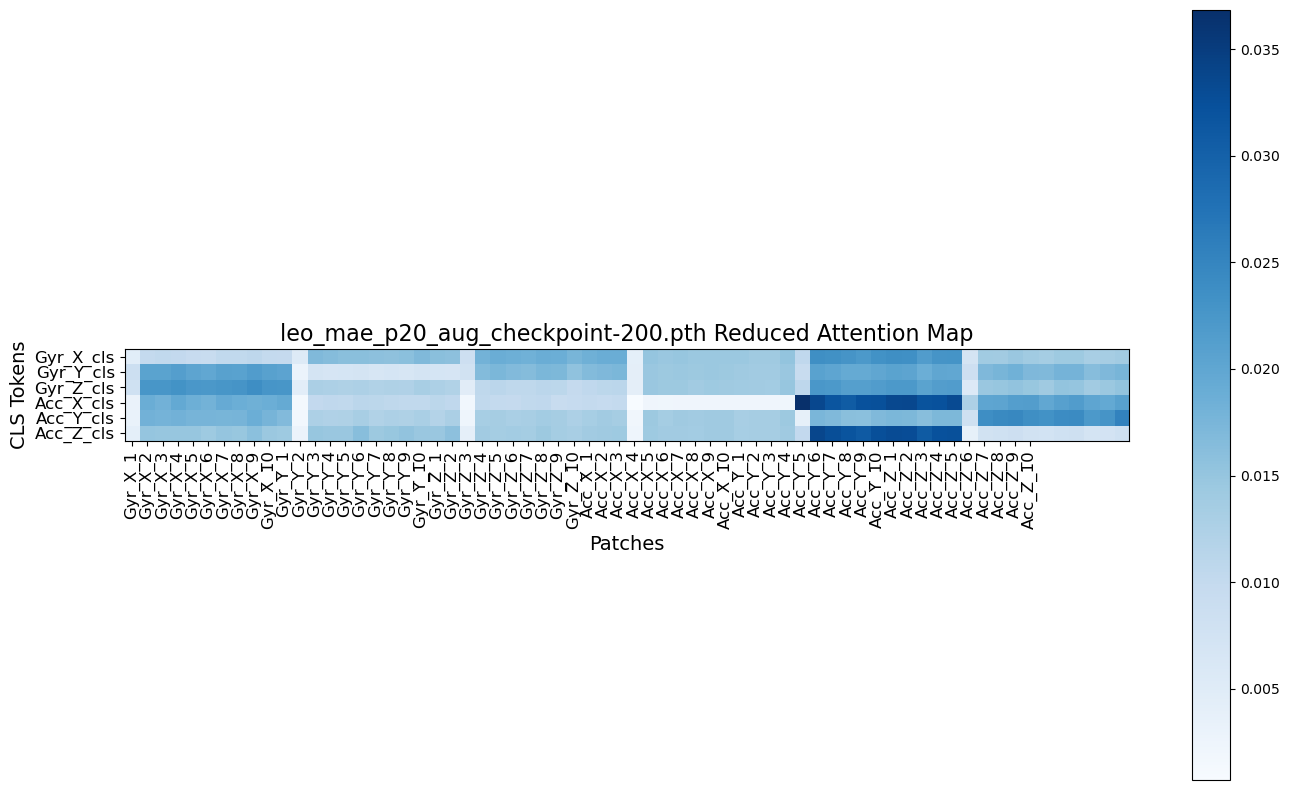

In [27]:
plot_cls(downstream_cls_attn_map_list,checkpoint_name, ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"])

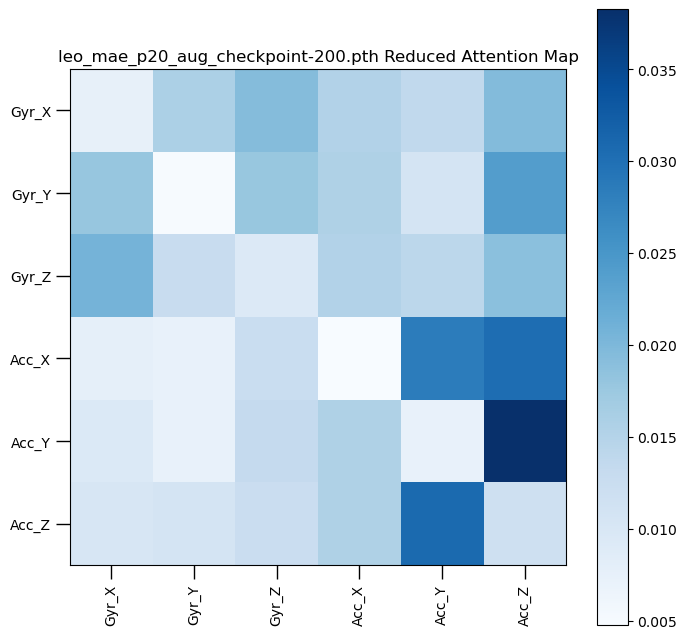

In [28]:
show_reduced_attention_map(downstream_attn_map.cpu())

## Individual View (One per activity)

In this section, we analyze how each patch contributes to the final classification output. We start by obtaining the full attention map, which has dimensions of 66 x (6*10 + 1). From this map, we extract the rows corresponding to the CLS token, resulting in an attention map of size 6 x 66. To isolate the contributions from the patches, we exclude the self-attention of the CLS token, reducing the attention map to 6 x 60. We then sum the columns to determine the total attention contribution from all patches to each CLS token, which results in a 1 x 60 attention map. This map is reshaped back to 6 x 10 to match the dimensions of the input patches, and finally, we visualize the reshaped attention map.

In [70]:
from leo_model_mae import MaskedAutoencoderViT
import timm
import torch
from main_linprobe import LinearProb

checkpoint_name = 'leo_mae_finetune_aug_p20_200ep_7class_checkpoint-499.pth'

backbone = MaskedAutoencoderViT(ts_len=200,patch_size=20,bert_pos_embed=False)
model = LinearProb(backbone,num_classes=7)
checkpoint = torch.load('../persistent-data/leo/output_dir/downstream/'+checkpoint_name,map_location='cpu')

checkpoint_model = checkpoint['model']
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

print(model.backbone.blocks[-1].attn)
model.backbone.blocks[-1].attn.forward = my_forward_wrapper(model.backbone.blocks[-1].attn)

_IncompatibleKeys(missing_keys=['backbone.decoder_blocks.0.norm1.weight', 'backbone.decoder_blocks.0.norm1.bias', 'backbone.decoder_blocks.0.attn.qkv.weight', 'backbone.decoder_blocks.0.attn.qkv.bias', 'backbone.decoder_blocks.0.attn.proj.weight', 'backbone.decoder_blocks.0.attn.proj.bias', 'backbone.decoder_blocks.0.norm2.weight', 'backbone.decoder_blocks.0.norm2.bias', 'backbone.decoder_blocks.0.mlp.fc1.weight', 'backbone.decoder_blocks.0.mlp.fc1.bias', 'backbone.decoder_blocks.0.mlp.fc2.weight', 'backbone.decoder_blocks.0.mlp.fc2.bias', 'backbone.decoder_blocks.1.norm1.weight', 'backbone.decoder_blocks.1.norm1.bias', 'backbone.decoder_blocks.1.attn.qkv.weight', 'backbone.decoder_blocks.1.attn.qkv.bias', 'backbone.decoder_blocks.1.attn.proj.weight', 'backbone.decoder_blocks.1.attn.proj.bias', 'backbone.decoder_blocks.1.norm2.weight', 'backbone.decoder_blocks.1.norm2.bias', 'backbone.decoder_blocks.1.mlp.fc1.weight', 'backbone.decoder_blocks.1.mlp.fc1.bias', 'backbone.decoder_blocks.1

In [71]:
# test sample slice # for TRANSITION(0): 6 ;
image_length = 200

test_seq_y = torch.Tensor(torch.load(f'data/{image_length}/y_test_all_mode.pt'))
                          
activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}
for i, activity in enumerate(activity_labels.values()):
    print(f"test sample slice # for {activity}({i}):", np.where(test_seq_y == i)[0][0],";")

test_seq = torch.Tensor(torch.load(f'data/{image_length}/X_test_all.pt')).permute(0, 1, 3, 2)
print(test_seq.shape)

test sample slice # for TRANSITION(0): 6 ;
test sample slice # for WALKING(1): 9 ;
test sample slice # for WALKING-DOWN(2): 19 ;
test sample slice # for WALKING-UP(3): 18 ;
test sample slice # for SITTING(4): 2 ;
test sample slice # for STANDING(5): 1 ;
test sample slice # for LAYING(6): 0 ;
torch.Size([793, 1, 6, 200])


In [72]:
def get_sample(model, test_seq, test_seq_y, index, mask_ratio=0, num_variates=6):
    # Extract and process the sample sequence
    sample = test_seq[index:index+1].squeeze(0)
    print(f"Sample shape: {sample.shape}")
    print(f"Ground truth: {test_seq_y[index:index+1]}")

    # Pass the sample through the model
    y = model(sample, mask_ratio=mask_ratio)
    
    #######################
    predicted_class = torch.argmax(y, dim=-1)  # Adjust the dimension as needed
    # Print the ground truth and prediction
    print(f"Prediction: {predicted_class}")
    # Check if the prediction matches the ground truth
    if predicted_class.item() == test_seq_y[index].item():  # Assuming test_seq_y[index] is a scalar
        print("The prediction is correct!")
    else:
        print("The prediction is incorrect.")
    #######################
    
    # Get attention maps
    attn_map = model.backbone.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()  # Average all heads
    print(f"Attention map shape: {attn_map.shape}")

    # Calculate number of patches
    num_patches = int(10 * (1 - mask_ratio)) + 1

    # Generate CLS token indices
    cls_token_indices = [i * num_patches for i in range(num_variates)]  # Adjust indices based on your setup

    # Select attention maps for CLS tokens
    attn_map_cls = attn_map[cls_token_indices, :]
    print(f"CLS token attention map shape: {attn_map_cls.shape}")

    return sample,attn_map,attn_map_cls,cls_token_indices


In [73]:
# Example usage:
index = 5
transition_sample, transition_attn_map, transition_cls_attn_map,transition_cls_token_indices = get_sample(model, test_seq, test_seq_y, index, mask_ratio=0)

Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([6.])


Prediction: tensor([6])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])


In [ ]:
show_attention_map(transition_attn_map)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import os

def preprocess_data(transition_sample, transition_cls_attn_map, cls_token_indices):
    time_series_data = transition_sample.squeeze()  # Shape: (6, 200)
    tmp = transition_cls_attn_map.sum(dim=0)  # (6,66) -> (66,)
    
    # Indices to ignore
    cls_token_indices = torch.tensor(cls_token_indices)
    all_indices = torch.arange(tmp.shape[0])
    filtered_indices = all_indices[~torch.isin(all_indices, cls_token_indices)]
    filtered_tensor = tmp[filtered_indices]

    attention_maps_for_variates = filtered_tensor.reshape(6, -1)
    
    return time_series_data, attention_maps_for_variates

def plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity, num_patches=10, save_dir=None):
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]
    cmap = plt.get_cmap('YlOrRd')  # Yellow-to-red color map

    fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a 3x2 grid of subplots
    axs = axs.flatten()  # Flatten the axs array to 1D for easy iteration

    patch_width = 200 / num_patches  # Determine the width of each patch

    for i in range(6):
        # Plot the time series data
        axs[i].plot(time_series_data[i], label=variate_labels[i], color='black')

        # Overlay the attention map as vertical bands
        att_map = attention_maps_for_variates[i]

        # Get the y-axis limits
        y_min, y_max = axs[i].get_ylim()

        for j in range(num_patches):
            x_start = j * patch_width
            x_end = (j + 1) * patch_width
            
            # Compute mean attention score for the current patch
            mean_attention_score = att_map[j].item()
            
            # Highlight the attention region
            axs[i].fill_betweenx(
                [y_min, y_max], 
                x_start, x_end, 
                color=cmap(mean_attention_score), 
                alpha=0.5, 
                label='Attention' if j == 0 else ""
            )

        axs[i].set_title(f'{activity}_{variate_labels[i]}')
        axs[i].legend()

    # Add a colorbar to the figure for the attention map
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axs, orientation='vertical', label='Attention Score')
    cbar.ax.set_position([0.92, 0.1, 0.03, 0.8])  # Adjust the colorbar position

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar

    # Save plot to file if save_dir is provided
    if save_dir:
        plot_filename = os.path.join(save_dir, f'{activity}.png')
        plt.savefig(plot_filename)
        plt.close(fig)  # Close the figure to free up memory


In [2]:
def process_all_samples(model, test_seq, test_seq_y, activity_slices, mask_ratio=0, save_html=False):
    """
    Process all test samples based on activity slices, generate attention maps, and plot the results.

    Parameters:
    - model: The model used for generating attention maps.
    - test_seq: The tensor containing test sequences.
    - test_seq_y: The tensor containing ground truth labels.
    - activity_slices: A dictionary mapping activity labels to slice indices.
    - mask_ratio: Ratio of masked tokens used in attention map generation.
    - save_html: Flag to save plots as HTML file.
    """
    
    # Create directory for saving plots if necessary
    save_dir = 'plots'
    if save_html and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    image_files = []  # List to store filenames of generated plots

    for label, index in activity_slices.items():
        torch.manual_seed(42)
        print(f"Start plotting for sample index {index} of activity '{label}'")
        # Get the sample and attention map
        transition_sample, transition_attn_map, transition_cls_attn_map, transition_cls_token_indices = get_sample(
                model, test_seq, test_seq_y, index, mask_ratio=mask_ratio)
            
        # Preprocess data
        time_series_data, attention_maps_for_variates = preprocess_data(
                transition_sample, transition_cls_attn_map, transition_cls_token_indices)
            
        # Plot results
        if save_html:
            plot_filename = os.path.join(save_dir, f'{label}.png')
            plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity=label, save_dir=save_dir)
            image_files.append(plot_filename)
        else:
            plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity=label)
        
        print('-----------------------------------------------------------------')

    if save_html:
        # Generate HTML content
        html_content = '<html><head><title>Plots</title></head><body>'
        for img_file in image_files:
            html_content += f'<h2>{os.path.basename(img_file)}</h2>'
            html_content += f'<img src="{img_file}" width="800"><br><br>'
        html_content += '</body></html>'
        
        # Save HTML content to file
        with open(label+'plots.html', 'w') as f:
            f.write(html_content)


# Define activity slices based on provided information
sample_indices = {
    "TRANSITION": 6,
    "WALKING": 9,
    "WALKING-DOWN": 19,
    "WALKING-UP": 18,
    "SITTING": 2,
    "STANDING": 1,
    "LAYING": 0
}

# Example usage
#process_all_samples(model, test_seq, test_seq_y, sample_indices, mask_ratio=0)


Start plotting for sample index 6 of activity 'TRANSITION'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])


/tmp/ipykernel_415575/793277263.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar


-----------------------------------------------------------------
Start plotting for sample index 9 of activity 'WALKING'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([1.])
Prediction: tensor([1])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])
-----------------------------------------------------------------
Start plotting for sample index 19 of activity 'WALKING-DOWN'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([2.])
Prediction: tensor([2])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])
-----------------------------------------------------------------
Start plotting for sample index 18 of activity 'WALKING-UP'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([3.])
Prediction: tensor([3])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66

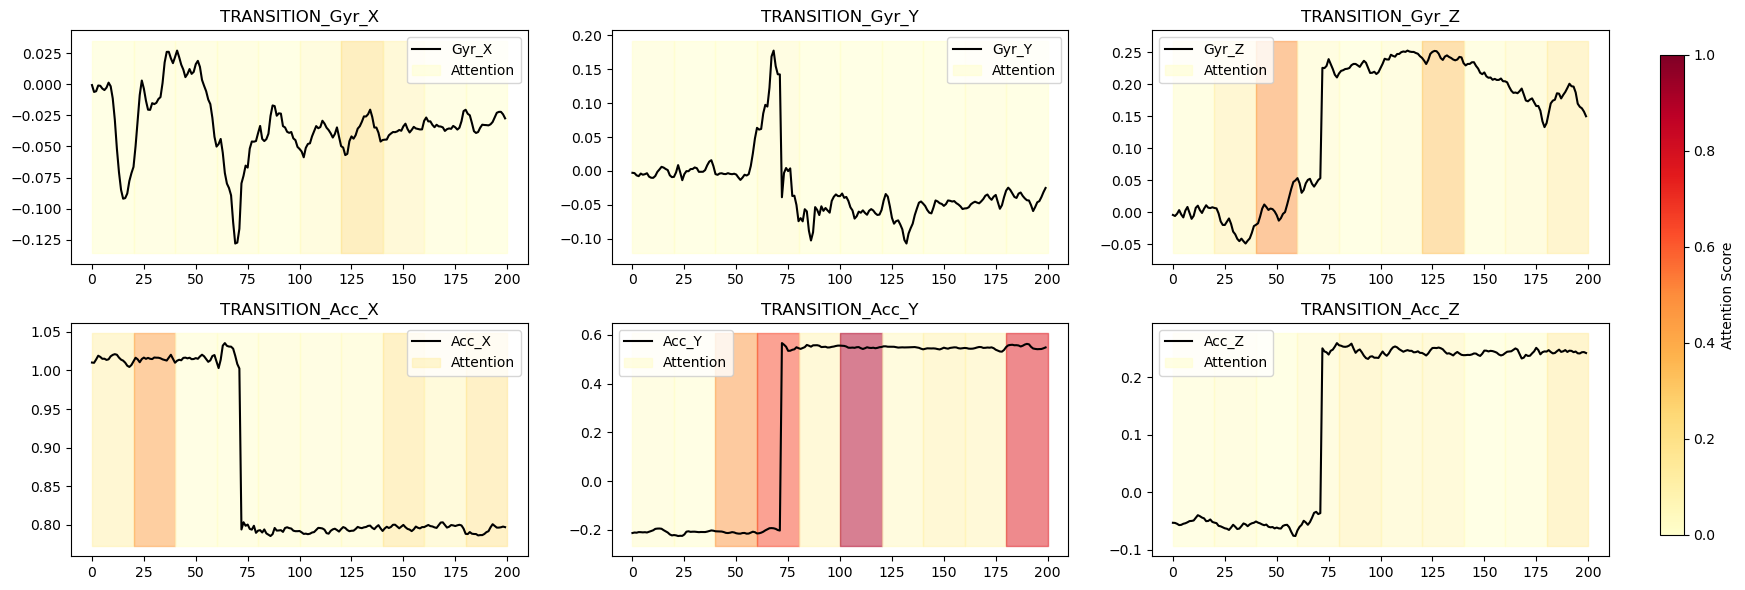

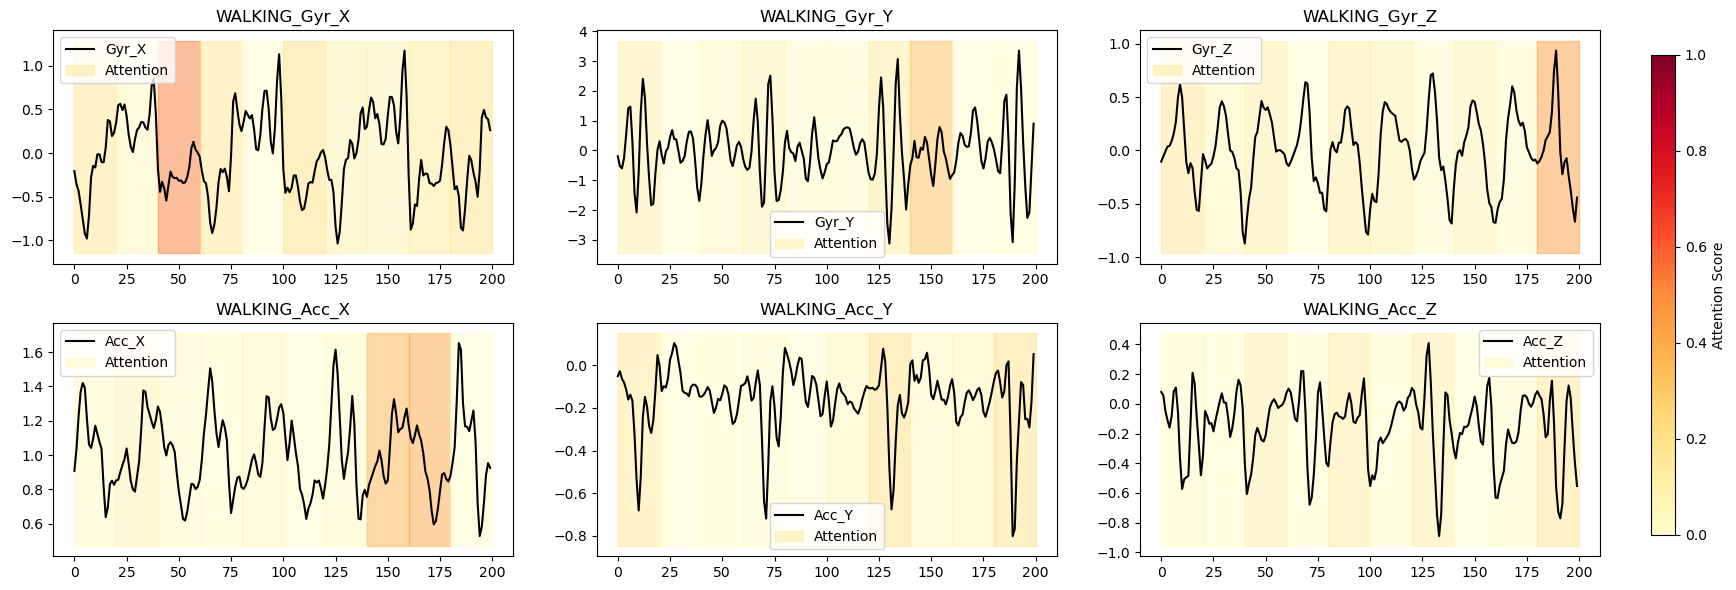

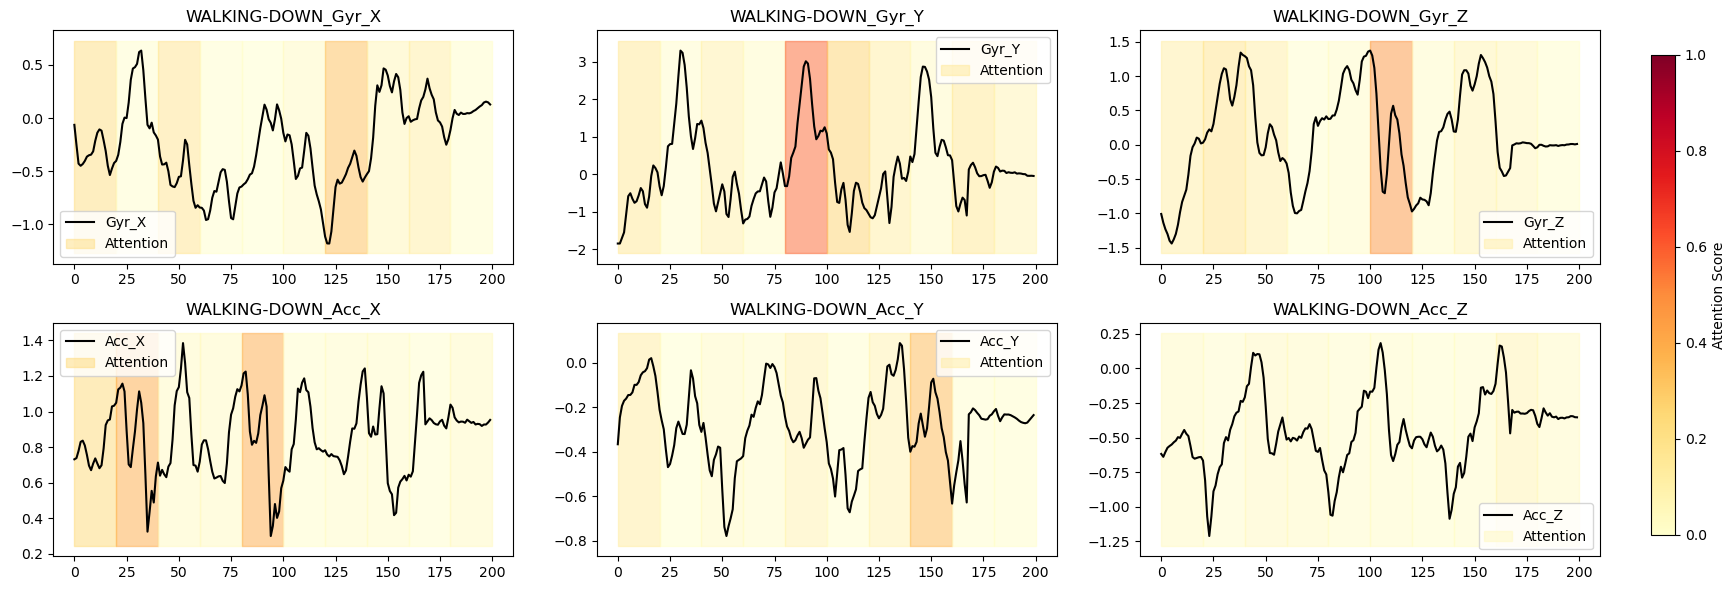

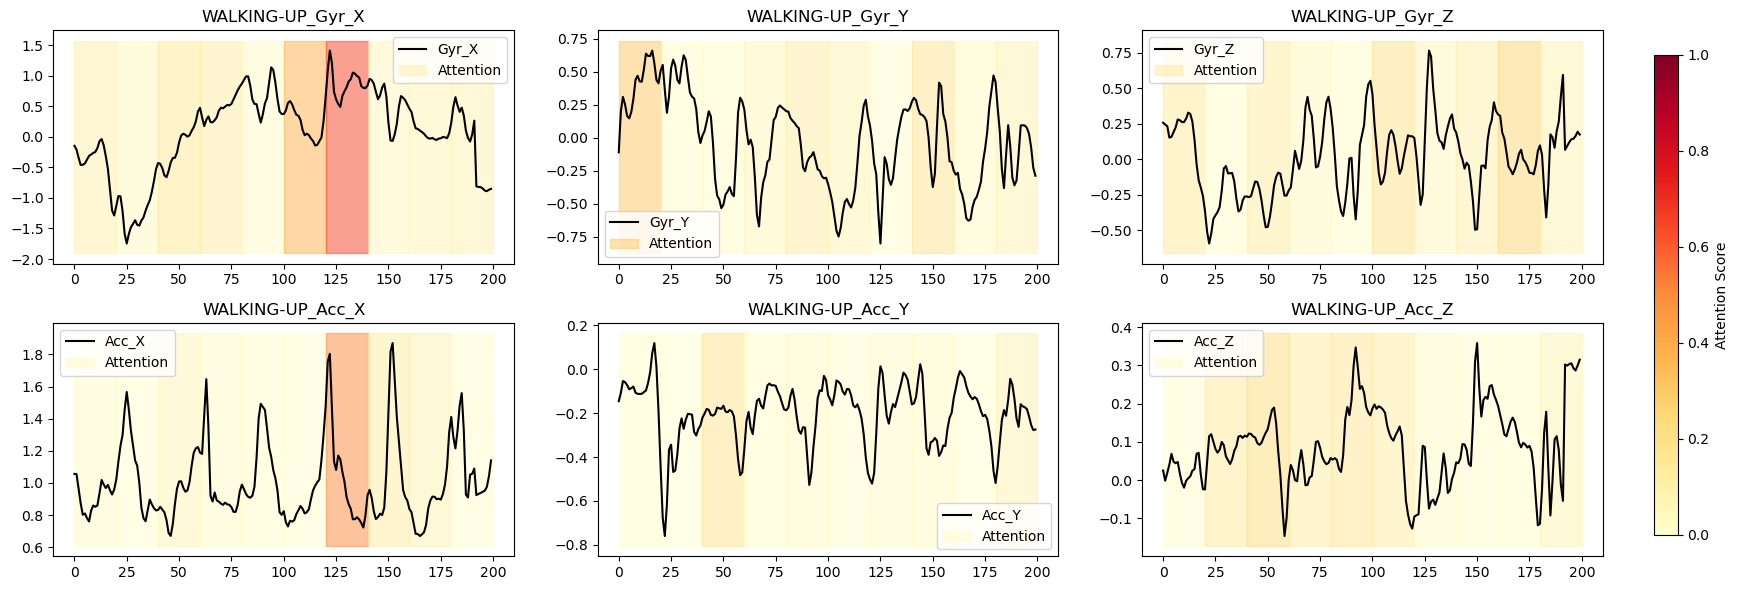

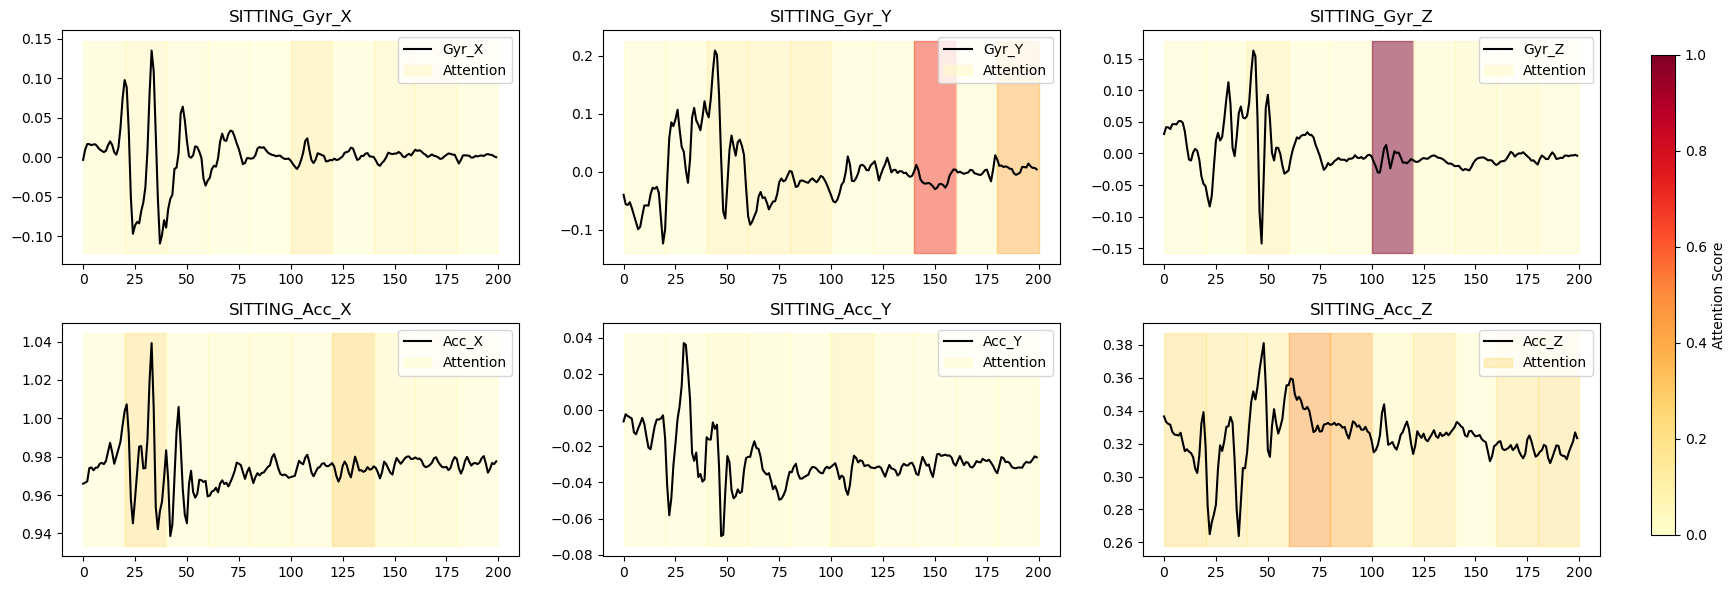

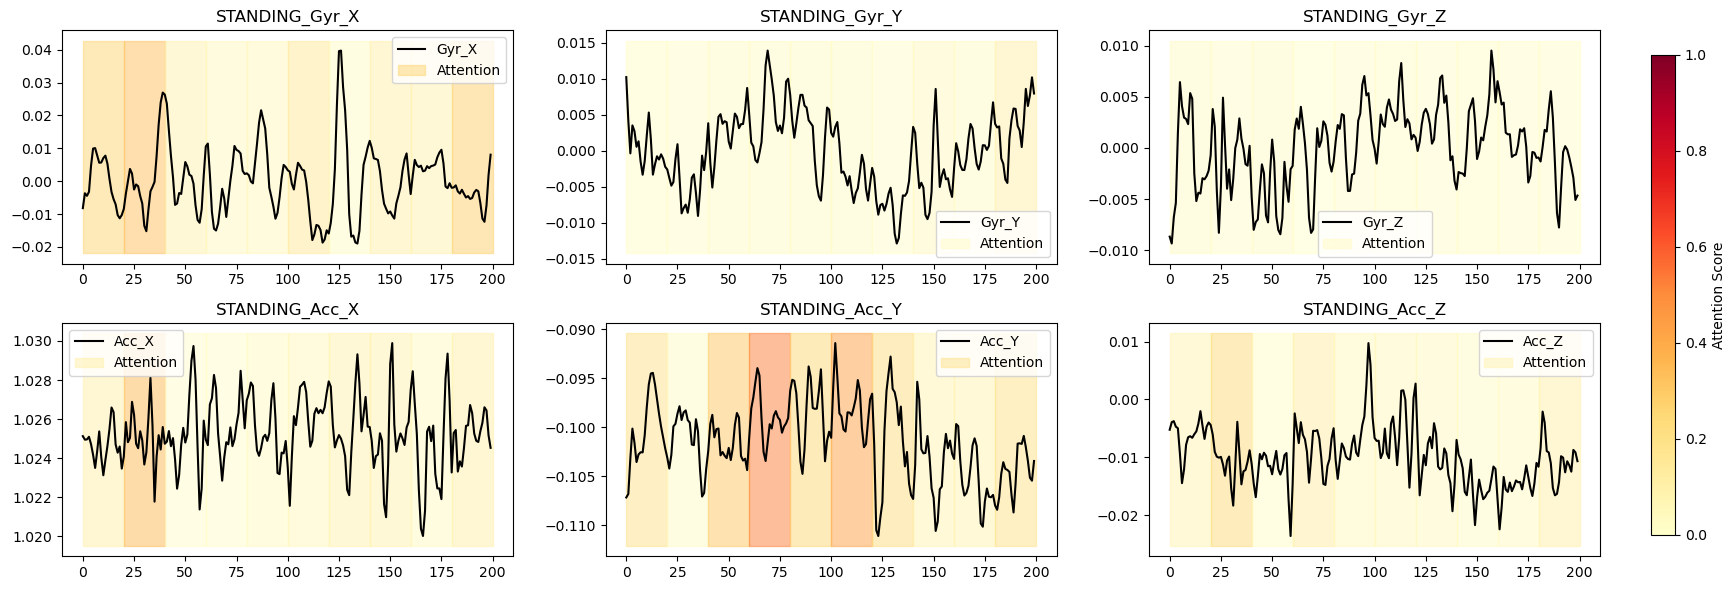

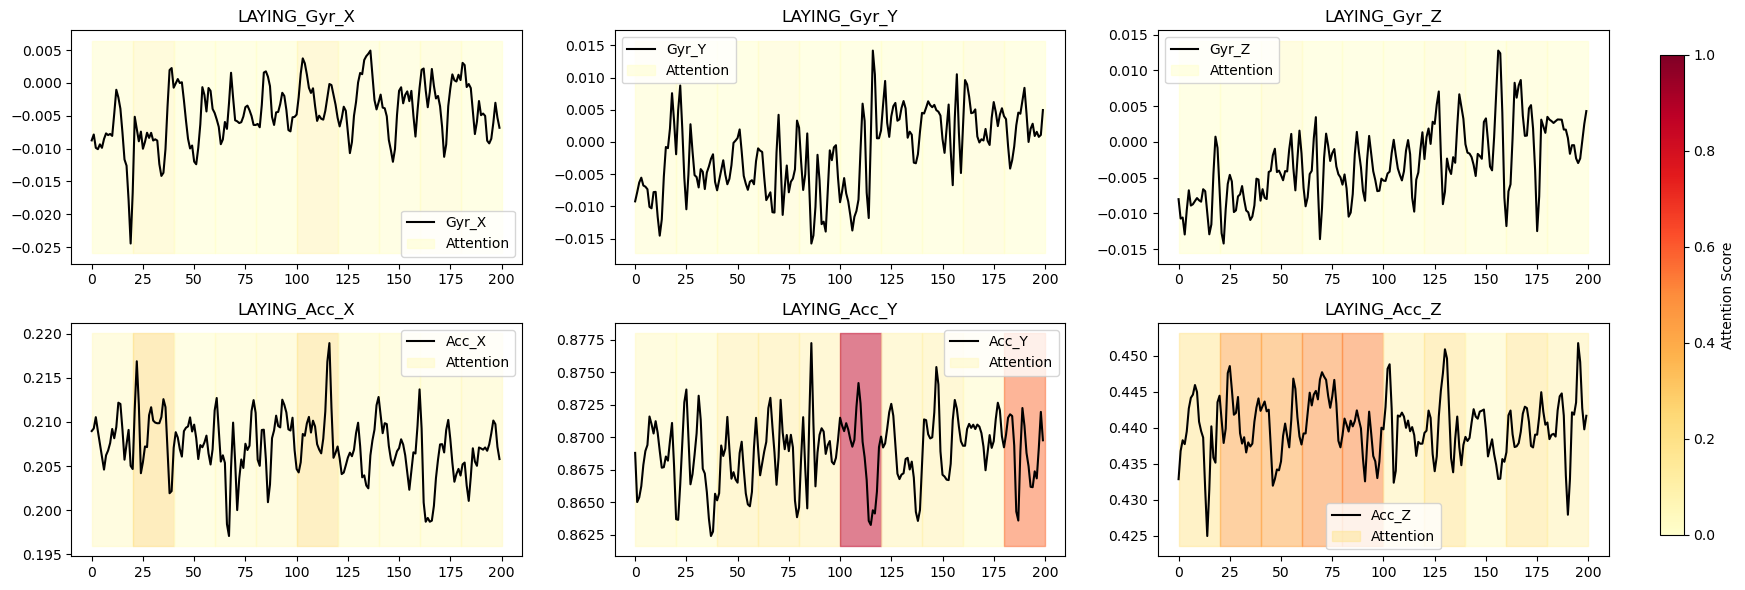

In [78]:
process_all_samples(model, test_seq, test_seq_y, sample_indices, mask_ratio=0)

### Transition Example

In [76]:
all_transition_sample_idx = np.where(test_seq_y == 0)[0]
transition_dict = {f"offline_transition_{sample_idx}": sample_idx for idx, sample_idx in enumerate(all_transition_sample_idx)}
# Print the resulting dictionary
print(transition_dict)

{'offline_transition_6': 6, 'offline_transition_12': 12, 'offline_transition_34': 34, 'offline_transition_43': 43, 'offline_transition_49': 49, 'offline_transition_75': 75, 'offline_transition_80': 80, 'offline_transition_133': 133, 'offline_transition_152': 152, 'offline_transition_205': 205, 'offline_transition_222': 222, 'offline_transition_241': 241, 'offline_transition_294': 294, 'offline_transition_323': 323, 'offline_transition_335': 335, 'offline_transition_340': 340, 'offline_transition_342': 342, 'offline_transition_435': 435, 'offline_transition_438': 438, 'offline_transition_466': 466, 'offline_transition_467': 467, 'offline_transition_528': 528, 'offline_transition_535': 535, 'offline_transition_542': 542, 'offline_transition_607': 607, 'offline_transition_623': 623, 'offline_transition_671': 671, 'offline_transition_684': 684, 'offline_transition_717': 717, 'offline_transition_719': 719, 'offline_transition_740': 740, 'offline_transition_777': 777}


In [77]:
process_all_samples(model, test_seq, test_seq_y, transition_dict, mask_ratio=0,save_html=True)

Start plotting for sample index 6 of activity 'offline_transition_6'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0])
The prediction is correct!
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])


/tmp/ipykernel_415575/793277263.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar


-----------------------------------------------------------------
Start plotting for sample index 12 of activity 'offline_transition_12'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([3])
The prediction is incorrect.
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])
-----------------------------------------------------------------
Start plotting for sample index 34 of activity 'offline_transition_34'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([1])
The prediction is incorrect.
Attention map shape: torch.Size([66, 66])
CLS token attention map shape: torch.Size([6, 66])
-----------------------------------------------------------------
Start plotting for sample index 43 of activity 'offline_transition_43'
Sample shape: torch.Size([1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([2])
The prediction is incorrect.
Attention map shape: torch.Size([66, 66])
CLS tok

## T-SNE Plot for Activity

In [66]:
from leo_model_mae import MaskedAutoencoderViT
import timm

## TODO: Load model
model = MaskedAutoencoderViT(ts_len=200,patch_size=20,bert_pos_embed=False)
checkpoint = torch.load('../persistent-data/leo/output_dir/'+checkpoint_name,map_location='cpu')

#checkpoint = torch.load('output_dir/ch_ind_normalize_checkpoint-9999.pth',map_location='cpu')
checkpoint_model = checkpoint['model']
    
msg = model.load_state_dict(checkpoint_model, strict=False)


In [67]:
from util.datasets import UCIHAR

dataset_train = UCIHAR(data_path='data/200', is_test=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

100%|██████████| 29/29 [00:03<00:00,  8.45it/s]


(1847, 768)


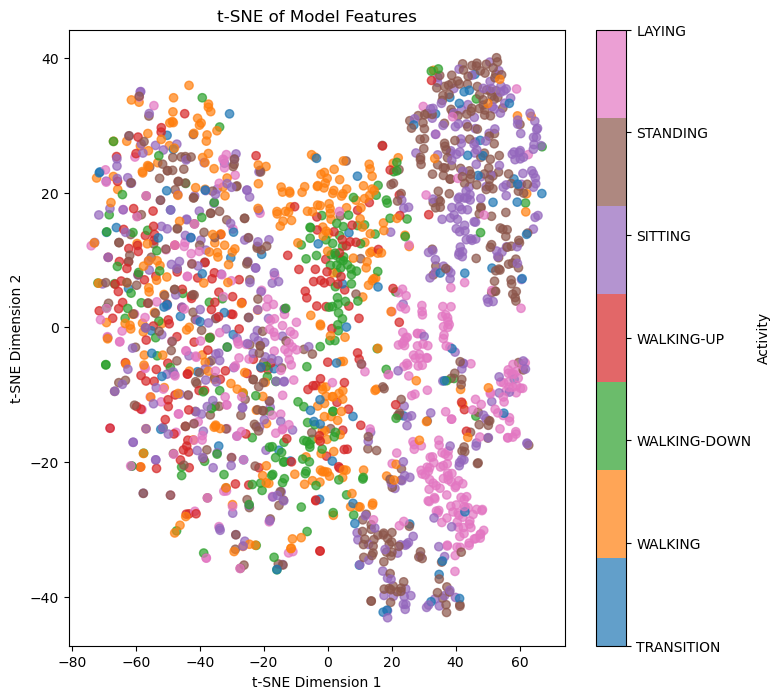

In [68]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib.colors import ListedColormap

# Define the activity labels
activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

def get_tsne(model, dataloader, n_components=2, perplexity=30, learning_rate=200):
    model.eval()
    features = []
    labels = []

    model = model.to('cuda')
    with torch.no_grad():
        for i, (x, label) in enumerate(tqdm(dataloader)):
            x = x.to('cuda')
            # x:[bs,nvar,L]
            # Extract features from the model (assuming model returns features)
            feature, _, _ = model.forward_encoder(x, mask_ratio=0)  # bs x nvar*(num_p+1) x E
            bs, _, E = feature.shape
            feature = feature.reshape(shape=(bs, 6, -1, E))
            # get a cls pooling as final feature
            feature = feature[:, :, 0, ...].mean(dim=1)  # bs,E

            features.append(feature.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Flatten lists
    features = np.concatenate(features, axis=0)
    print(features.shape)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
    tsne_results = tsne.fit_transform(features)

    return tsne_results, labels

def plot_tsne(tsne_results, labels, activity_labels):
    # Define a colormap with 7 distinct colors
    cmap = ListedColormap(plt.cm.tab10.colors[:7])

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.7)
    
    # Create a colorbar with activity names
    cbar = plt.colorbar(scatter, ticks=np.arange(7))
    cbar.set_label('Activity')
    cbar.set_ticklabels([activity_labels[i] for i in range(7)])  # Use activity names for ticks
    
    plt.title('t-SNE of Model Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Example usage:
tsne_results, labels = get_tsne(model, data_loader_train)
plot_tsne(tsne_results, labels, activity_labels)


## TSNE Plot for Variate

In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib.colors import ListedColormap

# Define the activity labels
activity_labels = {0: "Gyr_X", 1: "Gyr_Y", 2: "Gyr_Z", 3: "Acc_X", 4: "Acc_Y", 5: "Acc_Z"}

def get_tsne(model, dataloader, n_components=2, perplexity=30, learning_rate=200):
    model.eval()
    features = []
    labels = []

    model = model.to('cuda')
    with torch.no_grad():
        for x, _ in tqdm(dataloader):
            x = x.to('cuda')
            # Extract features from the model
            feature, _, _ = model.forward_encoder(x, mask_ratio=0)  # Shape: [bs, nvar*(num_p+1), E]
            bs, _, E = feature.shape
            
            # Reshape features
            feature = feature.reshape(shape=(bs, 6, -1, E))  # Adjust shape as needed
            
            # Append all CLS token into features list
            feature = feature[:, :, 0, ...]  # Shape: [bs, var, E]
            features.append(feature.cpu().numpy().reshape(bs * 6, E))
            
            labels.extend([np.arange(6)] * bs)

    # Flatten lists
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
    tsne_results = tsne.fit_transform(features)

    return tsne_results, labels

def plot_tsne(tsne_results, labels, activity_labels):
    # Define a colormap with as many distinct colors as you have labels
    cmap = ListedColormap(plt.cm.tab10.colors[:len(activity_labels)])

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.7)
    
    # Create a colorbar with activity names
    cbar = plt.colorbar(scatter, ticks=np.arange(len(activity_labels)))
    cbar.set_label('Activity')
    cbar.set_ticklabels([activity_labels[i] for i in range(len(activity_labels))])
    
    plt.title('t-SNE of Model Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Example usage:
tsne_results, labels = get_tsne(model, data_loader_train)
plot_tsne(tsne_results, labels, activity_labels)


NameError: name 'model' is not defined